In [24]:
from google.colab import files
files.upload()

Saving model.py to model.py


{'model.py': b'\nimport torch.nn as nn\nimport torch.nn.functional as F\n\nclass Net(nn.Module):\n      def __init__(self):\n          super(Net, self).__init__()\n\n          # Input Block\n          self.convblock1 = nn.Sequential(\n              nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), bias=False,padding = 1),\n              nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), bias=False, padding = 1),\n              nn.BatchNorm2d(32),\n              nn.ReLU(),\n              nn.Dropout(0.2)\n\n          ) # output_size = 32\n\n          #skip connections\n          self.skip1 = nn.Sequential(\n              nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(1, 1), bias=False),\n\n          ) # output\n\n          # CONVOLUTION BLOCK 1\n          self.convblock2 = nn.Sequential(\n              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), bias=False,stride=2),\n              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=

In [25]:
from __future__ import print_function
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from model import Net
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [26]:
class Cifar10SearchDataset(datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [27]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=1, fill_value=0.5, mask_fill_value = None),
        A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
   [
        A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
'''
trainset = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = Cifar10SearchDataset(root='./data', train=False,
                                       download=True,transform = test_transform)
test_loader =torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


 ship  bird   cat   dog


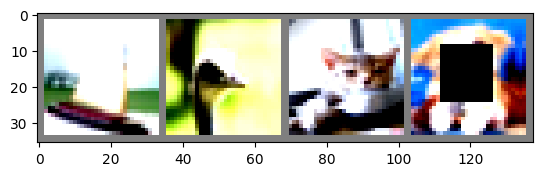

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [29]:

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
            Conv2d-2           [-1, 32, 32, 32]           4,608
       BatchNorm2d-3           [-1, 32, 32, 32]              64
              ReLU-4           [-1, 32, 32, 32]               0
           Dropout-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]              96
            Conv2d-7           [-1, 64, 15, 15]          18,432
            Conv2d-8          [-1, 128, 15, 15]          73,728
       BatchNorm2d-9          [-1, 128, 15, 15]             256
             ReLU-10          [-1, 128, 15, 15]               0
          Dropout-11          [-1, 128, 15, 15]               0
           Conv2d-12           [-1, 64, 11, 11]          73,728
           Conv2d-13             [-1, 32, 9, 9]          18,432
      BatchNorm2d-14             [

In [30]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [31]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 60
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.4023680686950684 Batch_id=390 Accuracy=33.67: 100%|██████████| 391/391 [00:19<00:00, 20.50it/s]



Test set: Average loss: 1.4603, Accuracy: 4673/10000 (46.73%)

EPOCH: 1


Loss=1.1385360956192017 Batch_id=390 Accuracy=50.83: 100%|██████████| 391/391 [00:18<00:00, 20.62it/s]



Test set: Average loss: 1.1453, Accuracy: 5893/10000 (58.93%)

EPOCH: 2


Loss=0.974221408367157 Batch_id=390 Accuracy=57.85: 100%|██████████| 391/391 [00:13<00:00, 29.22it/s]



Test set: Average loss: 1.0269, Accuracy: 6273/10000 (62.73%)

EPOCH: 3


Loss=0.9958378076553345 Batch_id=390 Accuracy=62.61: 100%|██████████| 391/391 [00:13<00:00, 29.52it/s]



Test set: Average loss: 1.0303, Accuracy: 6324/10000 (63.24%)

EPOCH: 4


Loss=0.7794274687767029 Batch_id=390 Accuracy=65.51: 100%|██████████| 391/391 [00:13<00:00, 29.80it/s]



Test set: Average loss: 0.8384, Accuracy: 7065/10000 (70.65%)

EPOCH: 5


Loss=0.8642524480819702 Batch_id=390 Accuracy=67.41: 100%|██████████| 391/391 [00:13<00:00, 29.99it/s]



Test set: Average loss: 1.0123, Accuracy: 6596/10000 (65.96%)

EPOCH: 6


Loss=0.7842854261398315 Batch_id=390 Accuracy=69.07: 100%|██████████| 391/391 [00:13<00:00, 30.03it/s]



Test set: Average loss: 0.8300, Accuracy: 7192/10000 (71.92%)

EPOCH: 7


Loss=1.06687593460083 Batch_id=390 Accuracy=70.25: 100%|██████████| 391/391 [00:13<00:00, 29.35it/s]



Test set: Average loss: 0.8396, Accuracy: 7091/10000 (70.91%)

EPOCH: 8


Loss=0.7952662110328674 Batch_id=390 Accuracy=71.47: 100%|██████████| 391/391 [00:14<00:00, 27.65it/s]



Test set: Average loss: 0.7547, Accuracy: 7465/10000 (74.65%)

EPOCH: 9


Loss=0.7685221433639526 Batch_id=390 Accuracy=72.56: 100%|██████████| 391/391 [00:13<00:00, 29.02it/s]



Test set: Average loss: 0.7577, Accuracy: 7434/10000 (74.34%)

EPOCH: 10


Loss=0.8713714480400085 Batch_id=390 Accuracy=73.16: 100%|██████████| 391/391 [00:13<00:00, 29.74it/s]



Test set: Average loss: 0.6431, Accuracy: 7787/10000 (77.87%)

EPOCH: 11


Loss=0.6313227415084839 Batch_id=390 Accuracy=73.96: 100%|██████████| 391/391 [00:13<00:00, 29.58it/s]



Test set: Average loss: 0.7147, Accuracy: 7557/10000 (75.57%)

EPOCH: 12


Loss=0.7534915804862976 Batch_id=390 Accuracy=74.55: 100%|██████████| 391/391 [00:13<00:00, 29.11it/s]



Test set: Average loss: 0.6391, Accuracy: 7828/10000 (78.28%)

EPOCH: 13


Loss=0.7481472492218018 Batch_id=390 Accuracy=75.22: 100%|██████████| 391/391 [00:13<00:00, 29.20it/s]



Test set: Average loss: 0.6234, Accuracy: 7877/10000 (78.77%)

EPOCH: 14


Loss=0.7905200719833374 Batch_id=390 Accuracy=75.76: 100%|██████████| 391/391 [00:13<00:00, 29.20it/s]



Test set: Average loss: 0.5885, Accuracy: 7970/10000 (79.70%)

EPOCH: 15


Loss=0.7347254157066345 Batch_id=390 Accuracy=76.02: 100%|██████████| 391/391 [00:13<00:00, 29.00it/s]



Test set: Average loss: 0.5616, Accuracy: 8057/10000 (80.57%)

EPOCH: 16


Loss=0.6232627630233765 Batch_id=390 Accuracy=76.51: 100%|██████████| 391/391 [00:13<00:00, 29.03it/s]



Test set: Average loss: 0.5828, Accuracy: 8081/10000 (80.81%)

EPOCH: 17


Loss=0.47549670934677124 Batch_id=390 Accuracy=76.86: 100%|██████████| 391/391 [00:13<00:00, 28.97it/s]



Test set: Average loss: 0.5649, Accuracy: 8100/10000 (81.00%)

EPOCH: 18


Loss=0.709934651851654 Batch_id=390 Accuracy=77.35: 100%|██████████| 391/391 [00:13<00:00, 29.82it/s]



Test set: Average loss: 0.6049, Accuracy: 8029/10000 (80.29%)

EPOCH: 19


Loss=0.6417734622955322 Batch_id=390 Accuracy=77.44: 100%|██████████| 391/391 [00:13<00:00, 28.74it/s]



Test set: Average loss: 0.5439, Accuracy: 8122/10000 (81.22%)

EPOCH: 20


Loss=0.6261945962905884 Batch_id=390 Accuracy=77.92: 100%|██████████| 391/391 [00:13<00:00, 28.50it/s]



Test set: Average loss: 0.5338, Accuracy: 8174/10000 (81.74%)

EPOCH: 21


Loss=0.5067722201347351 Batch_id=390 Accuracy=78.26: 100%|██████████| 391/391 [00:13<00:00, 28.79it/s]



Test set: Average loss: 0.4963, Accuracy: 8313/10000 (83.13%)

EPOCH: 22


Loss=0.700451672077179 Batch_id=390 Accuracy=78.65: 100%|██████████| 391/391 [00:13<00:00, 28.98it/s]



Test set: Average loss: 0.5217, Accuracy: 8241/10000 (82.41%)

EPOCH: 23


Loss=0.8033891916275024 Batch_id=390 Accuracy=78.51: 100%|██████████| 391/391 [00:13<00:00, 28.98it/s]



Test set: Average loss: 0.4997, Accuracy: 8298/10000 (82.98%)

EPOCH: 24


Loss=0.6703063249588013 Batch_id=390 Accuracy=78.69: 100%|██████████| 391/391 [00:13<00:00, 28.96it/s]



Test set: Average loss: 0.5266, Accuracy: 8234/10000 (82.34%)

EPOCH: 25


Loss=0.5641638040542603 Batch_id=390 Accuracy=79.34: 100%|██████████| 391/391 [00:13<00:00, 28.20it/s]



Test set: Average loss: 0.5031, Accuracy: 8296/10000 (82.96%)

EPOCH: 26


Loss=0.7083429098129272 Batch_id=390 Accuracy=79.43: 100%|██████████| 391/391 [00:13<00:00, 29.12it/s]



Test set: Average loss: 0.5130, Accuracy: 8258/10000 (82.58%)

EPOCH: 27


Loss=0.5699570178985596 Batch_id=390 Accuracy=79.45: 100%|██████████| 391/391 [00:13<00:00, 28.77it/s]



Test set: Average loss: 0.5157, Accuracy: 8290/10000 (82.90%)

EPOCH: 28


Loss=0.5050606727600098 Batch_id=390 Accuracy=79.72: 100%|██████████| 391/391 [00:13<00:00, 29.37it/s]



Test set: Average loss: 0.4948, Accuracy: 8377/10000 (83.77%)

EPOCH: 29


Loss=0.678232729434967 Batch_id=390 Accuracy=80.04: 100%|██████████| 391/391 [00:13<00:00, 29.03it/s]



Test set: Average loss: 0.5060, Accuracy: 8322/10000 (83.22%)

EPOCH: 30


Loss=0.46984243392944336 Batch_id=390 Accuracy=80.39: 100%|██████████| 391/391 [00:13<00:00, 28.62it/s]



Test set: Average loss: 0.4978, Accuracy: 8340/10000 (83.40%)

EPOCH: 31


Loss=0.6225526332855225 Batch_id=390 Accuracy=80.30: 100%|██████████| 391/391 [00:13<00:00, 28.05it/s]



Test set: Average loss: 0.4960, Accuracy: 8315/10000 (83.15%)

EPOCH: 32


Loss=0.7143083214759827 Batch_id=390 Accuracy=80.27: 100%|██████████| 391/391 [00:13<00:00, 28.56it/s]



Test set: Average loss: 0.5317, Accuracy: 8239/10000 (82.39%)

EPOCH: 33


Loss=0.5732730627059937 Batch_id=390 Accuracy=80.70: 100%|██████████| 391/391 [00:13<00:00, 28.56it/s]



Test set: Average loss: 0.4736, Accuracy: 8401/10000 (84.01%)

EPOCH: 34


Loss=0.7122035622596741 Batch_id=390 Accuracy=80.89: 100%|██████████| 391/391 [00:13<00:00, 28.82it/s]



Test set: Average loss: 0.4577, Accuracy: 8480/10000 (84.80%)

EPOCH: 35


Loss=0.7476009130477905 Batch_id=390 Accuracy=80.95: 100%|██████████| 391/391 [00:13<00:00, 28.41it/s]



Test set: Average loss: 0.4770, Accuracy: 8418/10000 (84.18%)

EPOCH: 36


Loss=0.6334075331687927 Batch_id=390 Accuracy=80.87: 100%|██████████| 391/391 [00:13<00:00, 28.76it/s]



Test set: Average loss: 0.5187, Accuracy: 8282/10000 (82.82%)

EPOCH: 37


Loss=0.5196126699447632 Batch_id=390 Accuracy=81.28: 100%|██████████| 391/391 [00:13<00:00, 28.64it/s]



Test set: Average loss: 0.4643, Accuracy: 8434/10000 (84.34%)

EPOCH: 38


Loss=0.5369989275932312 Batch_id=390 Accuracy=81.55: 100%|██████████| 391/391 [00:13<00:00, 28.70it/s]



Test set: Average loss: 0.4632, Accuracy: 8464/10000 (84.64%)

EPOCH: 39


Loss=0.7314294576644897 Batch_id=390 Accuracy=81.55: 100%|██████████| 391/391 [00:13<00:00, 28.23it/s]



Test set: Average loss: 0.4620, Accuracy: 8422/10000 (84.22%)

EPOCH: 40


Loss=0.3771548867225647 Batch_id=390 Accuracy=81.57: 100%|██████████| 391/391 [00:13<00:00, 28.54it/s]



Test set: Average loss: 0.4506, Accuracy: 8518/10000 (85.18%)

EPOCH: 41


Loss=0.5374798774719238 Batch_id=390 Accuracy=81.54: 100%|██████████| 391/391 [00:13<00:00, 28.10it/s]



Test set: Average loss: 0.4860, Accuracy: 8361/10000 (83.61%)

EPOCH: 42


Loss=0.49439001083374023 Batch_id=390 Accuracy=81.77: 100%|██████████| 391/391 [00:13<00:00, 28.87it/s]



Test set: Average loss: 0.4569, Accuracy: 8460/10000 (84.60%)

EPOCH: 43


Loss=0.5011767148971558 Batch_id=390 Accuracy=82.18: 100%|██████████| 391/391 [00:13<00:00, 28.62it/s]



Test set: Average loss: 0.4588, Accuracy: 8470/10000 (84.70%)

EPOCH: 44


Loss=0.49368149042129517 Batch_id=390 Accuracy=82.02: 100%|██████████| 391/391 [00:13<00:00, 28.59it/s]



Test set: Average loss: 0.4760, Accuracy: 8407/10000 (84.07%)

EPOCH: 45


Loss=0.526352047920227 Batch_id=390 Accuracy=82.30: 100%|██████████| 391/391 [00:13<00:00, 28.27it/s]



Test set: Average loss: 0.4421, Accuracy: 8524/10000 (85.24%)

EPOCH: 46


Loss=0.5100361108779907 Batch_id=390 Accuracy=82.57: 100%|██████████| 391/391 [00:13<00:00, 28.32it/s]



Test set: Average loss: 0.4532, Accuracy: 8515/10000 (85.15%)

EPOCH: 47


Loss=0.5728604793548584 Batch_id=390 Accuracy=82.07: 100%|██████████| 391/391 [00:13<00:00, 28.16it/s]



Test set: Average loss: 0.4442, Accuracy: 8514/10000 (85.14%)

EPOCH: 48


Loss=0.41810187697410583 Batch_id=390 Accuracy=82.26: 100%|██████████| 391/391 [00:13<00:00, 28.50it/s]



Test set: Average loss: 0.4321, Accuracy: 8558/10000 (85.58%)

EPOCH: 49


Loss=0.5665313601493835 Batch_id=390 Accuracy=82.42: 100%|██████████| 391/391 [00:13<00:00, 28.36it/s]



Test set: Average loss: 0.4308, Accuracy: 8560/10000 (85.60%)

EPOCH: 50


Loss=0.4016142785549164 Batch_id=390 Accuracy=82.24: 100%|██████████| 391/391 [00:13<00:00, 28.12it/s]



Test set: Average loss: 0.4411, Accuracy: 8485/10000 (84.85%)

EPOCH: 51


Loss=0.5607701539993286 Batch_id=390 Accuracy=82.70: 100%|██████████| 391/391 [00:13<00:00, 28.01it/s]



Test set: Average loss: 0.4401, Accuracy: 8514/10000 (85.14%)

EPOCH: 52


Loss=0.5320829153060913 Batch_id=390 Accuracy=82.80: 100%|██████████| 391/391 [00:13<00:00, 28.04it/s]



Test set: Average loss: 0.4505, Accuracy: 8484/10000 (84.84%)

EPOCH: 53


Loss=0.6194952130317688 Batch_id=390 Accuracy=82.98: 100%|██████████| 391/391 [00:13<00:00, 28.29it/s]



Test set: Average loss: 0.4366, Accuracy: 8573/10000 (85.73%)

EPOCH: 54


Loss=0.48906055092811584 Batch_id=390 Accuracy=83.11: 100%|██████████| 391/391 [00:13<00:00, 28.40it/s]



Test set: Average loss: 0.4328, Accuracy: 8579/10000 (85.79%)

EPOCH: 55


Loss=0.4764866828918457 Batch_id=390 Accuracy=83.33: 100%|██████████| 391/391 [00:13<00:00, 28.15it/s]



Test set: Average loss: 0.4311, Accuracy: 8575/10000 (85.75%)

EPOCH: 56


Loss=0.48168429732322693 Batch_id=390 Accuracy=83.08: 100%|██████████| 391/391 [00:14<00:00, 27.78it/s]



Test set: Average loss: 0.4400, Accuracy: 8528/10000 (85.28%)

EPOCH: 57


Loss=0.4452303946018219 Batch_id=390 Accuracy=83.13: 100%|██████████| 391/391 [00:14<00:00, 27.56it/s]



Test set: Average loss: 0.4814, Accuracy: 8423/10000 (84.23%)

EPOCH: 58


Loss=0.43992385268211365 Batch_id=390 Accuracy=83.46: 100%|██████████| 391/391 [00:13<00:00, 28.02it/s]



Test set: Average loss: 0.4220, Accuracy: 8610/10000 (86.10%)

EPOCH: 59


Loss=0.4212374687194824 Batch_id=390 Accuracy=83.26: 100%|██████████| 391/391 [00:13<00:00, 28.08it/s]



Test set: Average loss: 0.4285, Accuracy: 8546/10000 (85.46%)

